In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os

# import functions
from pysrc.load_data import load_data
from pysrc.load_spec import load_spec
# from pysrc.dfm import dfm
from pysrc.summarize import summarize
from pysrc.dfm import dfm

np.seterr(over='raise', under='raise', invalid='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Table 1: Model specification
              SeriesID                   SeriesName                 Units  \
0               PAYEMS           Payroll Employment  Thousands of Persons   
1               JTSJOL                 Job Openings             Thousands   
2             CPIAUCSL         Consumer Price Index                 Index   
3              DGORDER         Durable Goods Orders           $, Millions   
4                RSAFS                 Retail Sales           $, Millions   
5               UNRATE            Unemployment Rate                     %   
6                HOUST               Housing Starts    Thousands of Units   
7               INDPRO        Industrial Production                 Index   
8              DSPIC96              Personal Income   Chained $, Billions   
9              BOPTEXP                      Exports           $, Millions   
10             BOPTIMP                      Imports           $, Millions   
11             TTLCONS        Construction Spen

/Users/ejowik001/Desktop/Github/Nowcasting/pysrc/load_spec.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  blocks = raw_data[block_cols].fillna(0).astype(int).values


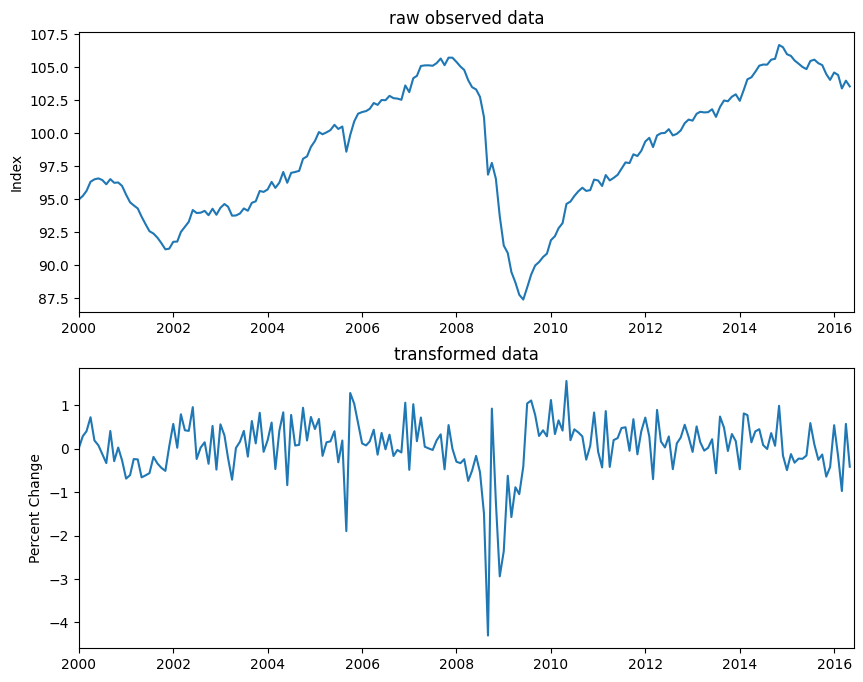




Table 3: Block Loading Structure
                             1global  2soft  3real  4labor
Payroll_Employment                 1      0      0       1
Job_Openings                       1      0      0       1
Consumer_Price_Index               1      0      0       0
Durable_Goods_Orders               1      0      1       0
Retail_Sales                       1      0      1       0
Unemployment_Rate                  1      0      0       1
Housing_Starts                     1      0      1       0
Industrial_Production              1      0      1       0
Personal_Income                    1      0      1       0
Exports                            1      0      1       0
Imports                            1      0      1       0
Construction_Spending              1      0      1       0
Import_Price_Index                 1      0      0       0
Core_Consumer_Price_Index          1      0      0       0
Core_PCE_Price_Index               1      0      0       0
PCE_Price_Index     

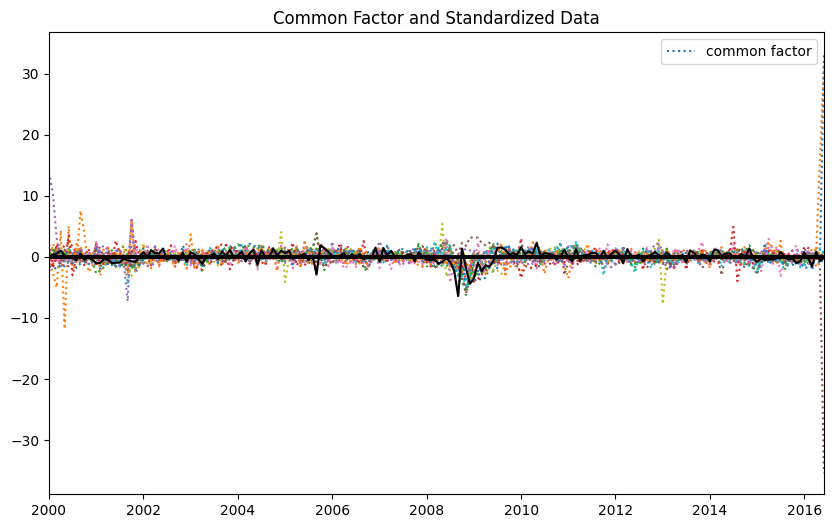

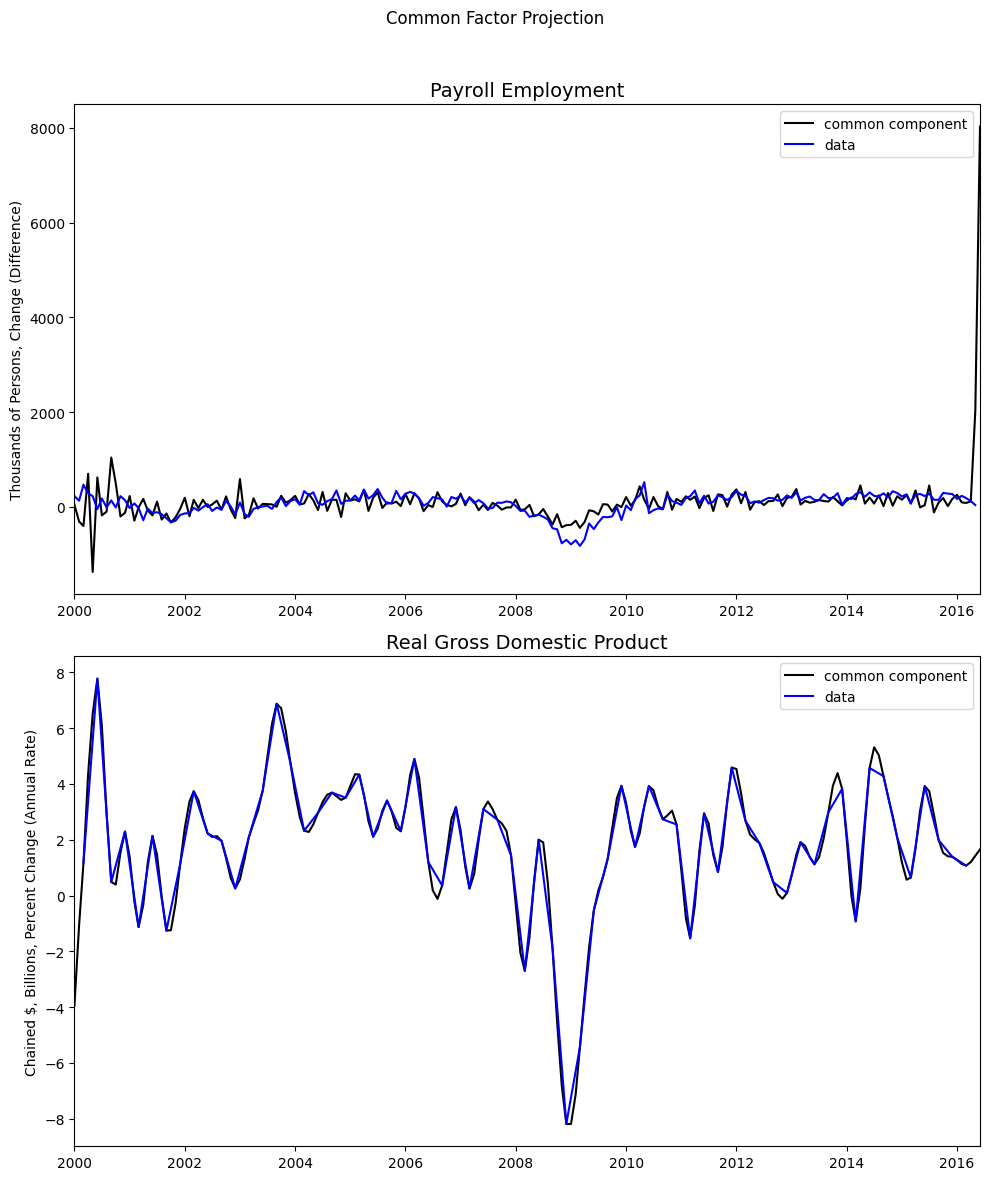

In [2]:
### Dynamic factor model (DFM) ############################################
# This script estimates a dynamic factor model (DFM) using a panel of
# monthly and quarterly series.
###########################################################################


## Clear workspace and set paths.
# close all; clear; clc;
# addpath('functions');


## User inputs.
vintage = '2016-06-29'; # vintage dataset to use for estimation
country = 'US';         # United States macroeconomic data
sample_start = datetime.strptime('2000-01-01', '%Y-%m-%d'); # estimation sample


## Load model specification and dataset.
# Load model specification structure `Spec`
Spec = load_spec('Spec_US_example.xls');
# Parse `Spec`
SeriesID, SeriesName, Units, UnitsTransformed = Spec['seriesid'], Spec['seriesname'], Spec['units'], Spec['unitstransformed']

# Load data
datafile = os.path.join('data', country, f'{vintage}.xls');
X, Time, Z = load_data(datafile, Spec, sample_start);
summarize(X,Time,Spec,vintage); # summarize data


## Plot raw and transformed data.
# Industrial Production (INDPRO) <fred.stlouisfed.org/series/INDPRO>
idxSeries = SeriesID.index("INDPRO")
t_obs = ~np.isnan(X[:, idxSeries])

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.box(True)
plt.plot(Time[t_obs], Z[t_obs, idxSeries])
plt.title('raw observed data')
plt.ylabel(Units[idxSeries])
plt.xlim(Time[0], Time[-1])

plt.subplot(2, 1, 2)
plt.box(True)
plt.plot(Time[t_obs], X[t_obs, idxSeries])
plt.title('transformed data')
plt.ylabel(UnitsTransformed[idxSeries])
plt.xlim(Time[0], Time[-1])
plt.show(); # to display plot

## Run dynamic factor model (DFM) and save estimation output as 'ResDFM'.
# threshold = 1e-4; # Set to 1e-5 for more robust estimates
threshold = 1e-5;

Res = dfm(X,Spec);
# save('ResDFM','Res','Spec');

## Plot common factor and standardized data.
plt.figure(figsize=(10, 6))
plt.plot(Time, Res['x_sm'], ':')  # hold on;
plt.plot(Time, Res['Z'][:, :] * Res['C'][idxSeries, :], 'k', linewidth=1.5)
plt.box(True)  # box on;
plt.xlim(Time[0], Time[-1])
plt.title('Common Factor and Standardized Data')
plt.legend(['common factor'])  # legend boxoff;
plt.show()  # to display plot

# ## Plot projection of common factor onto Payroll Employment and GDP.
plt.figure(figsize=(10, 12))

# Main title for the entire figure
plt.suptitle('Common Factor Projection', fontsize=12)

# First subplot - projection of common factor onto PAYEMS
plt.subplot(2, 1, 1)
idxSeries = SeriesID.index("PAYEMS")
t_obs = ~np.isnan(X[:, idxSeries])
CommonFactor = Res["C"][idxSeries, :5] @ Res["Z"][:, :5].T * Res["Wx"][idxSeries] + Res["Mx"][idxSeries]
plt.plot(Time, CommonFactor, 'k')
plt.plot(Time[t_obs], X[t_obs, idxSeries], 'b')
plt.box(True)
plt.title(SeriesName[idxSeries], fontsize=14)
plt.xlim(Time[0], Time[-1])
plt.ylabel(f'{Units[idxSeries]}, {UnitsTransformed[idxSeries]}')
plt.legend(['common component', 'data'])

# Second subplot - projection of common factor onto GDPC1
plt.subplot(2, 1, 2)
idxSeries = SeriesID.index("GDPC1")
t_obs = ~np.isnan(X[:, idxSeries])
CommonFactor = Res["C"][idxSeries] @ Res["Z"][:, :].T * Res["Wx"][idxSeries] + Res["Mx"][idxSeries]
plt.plot(Time, CommonFactor, 'k')
plt.plot(Time[t_obs], X[t_obs, idxSeries], 'b')
plt.box(True)
plt.title(SeriesName[idxSeries], fontsize=14)
plt.xlim(Time[0], Time[-1])
plt.ylabel(f'{Units[idxSeries]}, {UnitsTransformed[idxSeries]}')
plt.legend(['common component', 'data'])

# Adjust layout to prevent overlap between titles and labels
plt.tight_layout(rect=[0, 0, 1, 0.96])